# 1. Mining Diamond Data - Blue Nile®

## (a) Introduction
In this series of notebooks we are mining diamond data from merchants on the web, and subsequently using Machine Learning to be able to predict the price of a diamond. Diamond merchants often display data on the diamonds they are selling so people can peruse them and make a purchase online. They'll also usually have a comparison element with lots of features (the 5 C's etc.). Really though, if you're anything like me (a noob jeweller), how can you tell how the diamond is priced based on these features? I guess you'd have to take the merchants' word on it... 

What we need is data, and a regression algorithm looking at price. This notebook is the first in the series, and in it we'll tackle scraping Blue Nile® data from [their website](https://www.bluenile.com/uk/diamond-search) (soz Blue Nile... but thx for the data). 

In all seriousness, this data is the property of Blue Nile®, so please be respectful. I try and stick to web scraping best practises in these scripts, so if you are going to use it, please keep these in. They mostly revolve around slowing the functions down, which I realise may be frustrating, but let's keep to the code people.

We'll start by importing our packages and defining a couple of functions.

## (b) Import packages / define functions

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [12, 7]


from bs4 import BeautifulSoup
import requests
import re

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains

import itertools
import time # To help slow our functions down and time them
import random # To assign random floats to breaks, hiding predictable patterns

The below two functions are essential to working with HTML data, and we'll use these a lot throughout the notebook.

In [62]:
def pause_random(start=0.3, stop=2):
    """
    Pause the function for a random amount of time between the two integers entered.
    """
    time.sleep(random.uniform(start, stop))

In [63]:
def get_page_content(page_link):
    """
    Scrape the targeted HTML and store as a bs object
    """
    page_response = requests.get(page_link, timeout=5)
    page_content = BeautifulSoup(page_response.content)
    return(page_content)

In [64]:
def cleanhtml(raw_html):
    """
    Remove HTML tags from string.
    """
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return(cleantext)

## (c) Prepare Blue Nile® dataset

In this section we create a function to prepare the Blue Nile table, and do some intial exploration to help our final crawler save time.
For reference, I denote Blue Nile® as `bn` for short.

In [65]:
# For conciseness, Blue Nile we will denote as 'bn'
bn_link = 'https://www.bluenile.com/uk/diamond-search'

In [66]:
# Start web driver
browser = webdriver.Chrome('C:/Users/Edward Sims/Downloads/chromedriver.exe')
browser.get(bn_link)
pause_random()

In [67]:
def prep_bn_table(link):
    """
    Opens webdriver and prepares the table for scraping.
    """
    
    # Continue past the cookie notice if it exists
    try:
        cookie_continue = browser.find_element_by_xpath('/html/body/div[1]/button[3]')
        cookie_continue.click()
    except:
        pass

    # If the 360 view option is checked, uncheck it
    view_checkbox_status = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[4]/div[2]/div/div/div[1]/div/div')
    view_checkbox_status = str(view_checkbox_status.get_attribute('innerHTML'))
    if 'checked' in view_checkbox_status:
        view_checkbox = browser.find_element_by_class_name('bn-checkbox')
        view_checkbox.click()
        pause_random()

    # If astor option is checked, uncheck it
    astor_checkbox_status = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[5]/div[2]/div/div/div[1]/div/div')
    astor_checkbox_status = str(astor_checkbox_status.get_attribute('innerHTML'))
    if 'checked' in astor_checkbox_status:
        astor_checkbox = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[5]/div[2]/div/div')
        astor_checkbox.click()
        pause_random()
        
    # If more filters is unselected, select it    
    filter_status = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[13]/span')
    filter_status = str(filter_status.get_attribute('innerHTML'))
    if 'More' in filter_status:
        more_filters = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[13]')
        more_filters.click()
    
    # Add extra options if they are not already added
    polish_add = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[12]/div[1]/div[1]/div/div')
    symmetry_add = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[12]/div[2]/div[1]/div/div')
    fluorescence_add = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[12]/div[3]/div[1]/div/div')
    depth_add = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[12]/div[4]/div[1]/div/div')
    table_add = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[12]/div[5]/div[1]/div/div')
    lw_add = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[12]/div[6]/div[1]/div/div')
    
    feature_add_all = [polish_add, symmetry_add, fluorescence_add, depth_add, table_add, lw_add]
    for feature_add in feature_add_all:
        if 'toggled' not in str(feature_add.get_attribute('outerHTML')):
            feature_add.click()
            pause_random()
            
    culet_add = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[12]/div[8]/div[2]/button')
    if 'active' not in str(culet_add.get_attribute('outerHTML')):
        culet_add.click()
        pause_random()
    
    # Add in all types of shape
    round_details = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[6]/div[2]/div/div[1]/div[3]')
    princess_details = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[6]/div[2]/div/div[2]/div[3]')
    emerald_details = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[6]/div[2]/div/div[3]/div[3]')
    asscher_details = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[6]/div[2]/div/div[4]/div[3]')
    cushion_details = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[6]/div[2]/div/div[5]/div[3]')
    marquise_details = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[6]/div[2]/div/div[6]/div[3]')
    radiant_details = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[6]/div[2]/div/div[7]/div[3]')
    oval_details = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[6]/div[2]/div/div[8]/div[3]')
    pear_details = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[6]/div[2]/div/div[9]/div[3]')
    heart_details = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[6]/div[2]/div/div[10]/div[3]')
    
    shape_details_all = [round_details, princess_details, emerald_details, asscher_details, cushion_details, 
                         marquise_details, radiant_details, oval_details, pear_details, heart_details]
    
    for shape_details in shape_details_all:
        if 'selected' not in str(shape_details.get_attribute('outerHTML')):
            shape_details.click()
            pause_random()

In [68]:
# Open and prepare the bn table for scraping
prep_bn_table(bn_link)

The difficulty with scraping the table is that a maximum of 1,000 results are displayed. And the prices of diamonds are hugely skewed around the £600-£2,000 price range. 

So we've arrived at our first major problem: 
 - If we increment our price by small amounts, it'll take weeks (umm no thanks)
 - If we increment them by large amounts, we'll miss out loads of data from the price ranges with high frequencies.

The best thing that we can do is take some inital data on the approximate distribution, and go from there.

The below will loop through price ranges and scrape the numbers of results in each interval, so we can gain a rough picture of the distribution of our dataset. This will take a little time, but should help us cut down the time our final looping function takes. 

N.B. This took ~20mins to complete.

In [108]:
def collect_price_freqs():
    """
    Loops through price, scrapes and stores the 
    number of results at each range.
    """
    
    def get_num_results():
        """
        Scrapes the number of results shown in the price range.    
        """
        results_path = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[2]/div[4]/button[1]/span[2]')
        # Scrape HTML and clean
        results_val = cleanhtml(str(BeautifulSoup(results_path.get_attribute('innerHTML'))))
        # Strip  punctuation, and convert to integer
        results_val = int(re.sub(r'[^\w\s]','', results_val))
        return(results_val)

    # Create a dataframe with our new headers
    headers = ['price_range','freq']
    bn_price_freqs = pd.DataFrame(columns=headers)
    
    # Min and max price locations
    min_price_box = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[7]/div[2]/div/div[1]/input[1]')
    max_price_box = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[7]/div[2]/div/div[1]/input[2]')
    
    # Assign default interval value
    price_interval = 10000
    
    # Get min and max values (without £ and comma values)
    min_price_value = int(min_price_box.get_attribute('value')[1:].replace(',', ''))
    min_price_value = min_price_value - 1 # Minus 1, so we can add 1 in the loop
    max_price_value = int(max_price_box.get_attribute('value')[1:].replace(',', ''))
    
    total_freq = get_num_results()
    
    # Find a neutral zone to click on
    neutral = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[7]/div[1]/h3')
    cumul_freq = 0 # To cumulitively add the freqs as we go
    start = time.time()
    
    # Loop through prices
    for min_val in range(min_price_value, max_price_value, price_interval):
        
        lower_price = min_val + 1 # Add 1 so there are no overlapping intervals
        higher_price = min_val + price_interval
        
        # Edit max price
        max_price_box.click()
        max_price_box.send_keys(Keys.BACKSPACE)
        max_price_box.send_keys(str(higher_price)) 
        neutral.click()
        time.sleep(random.uniform(0.3,2))
        
        # Edit min price            
        min_price_box.click()
        min_price_box.send_keys(Keys.BACKSPACE)
        min_price_box.send_keys(str(lower_price))
        neutral.click()
        time.sleep(random.uniform(0.3,1))         
        
        freq = get_num_results()   
        cumul_freq = cumul_freq + freq
        
        # Store the range and keep going
        price_range = str(lower_price) + ' to ' + str(higher_price)
        results = [price_range, freq]
        
        bn_price_freqs = bn_price_freqs.append(dict(zip(headers,results)), ignore_index=True)
        print(total_freq-cumul_freq)

        if total_freq - cumul_freq <= 999:
            print(results)
            break
    # Add variables to df for min and max values
    min_vals = []
    max_vals = []
    for int_range in bn_price_freqs['price_range']:
        min_vals.append(int(int_range.split(' to ')[0]))
        max_vals.append(int(int_range.split(' to ')[1]))
        
    bn_price_freqs['min_price'] = min_vals
    bn_price_freqs['max_price'] = max_vals
    
    end = time.time()
    print(end - start, 'secs to complete')
    print('Total results: ', total_freq)
    print(results)
    return(bn_price_freqs)

In [109]:
# Collect the frequencies and remove all ranges with no results
bn_price_freqs = collect_price_freqs()
bn_price_freqs.head()

19172
8587
5347
3755
2781
2132
1725
1426
1206
1017
863
['100194 to 110193', 154]
54.7300500869751 secs to complete
Total results:  215861


,price_range,freq,min_price,max_price
0,194 to 10193,196689,194,10193
1,10194 to 20193,10585,10194,20193
2,20194 to 30193,3240,20194,30193
3,30194 to 40193,1592,30194,40193
4,40194 to 50193,974,40194,50193


In [97]:
print('cumul_freq: ', cumul_freq)
print('total_freq: ', total_freq)

cumul_freq:  215904
total_freq:  215907


In [103]:
cumul_freq

215904

In [99]:
bn_price_freqs

,price_range,freq,min_price,max_price
0,194 to 10193,196735,194,10193
1,10194 to 20193,10585,10194,20193
2,20194 to 30193,3240,20194,30193
3,30194 to 40193,1592,30194,40193
4,40194 to 50193,974,40194,50193
5,50194 to 60193,2778,50194,60193


In [100]:
sum(bn_price_freqs['freq'])

215904

In [102]:
total_freq-215904

3

In [13]:
# Remove intervals with zero frequency
bn_price_freqs_no_zero = bn_price_freqs[bn_price_freqs.freq != 0]
#bn_price_freqs_no_zero = bn_price_freqs_no_zero.reindex(index=bn_price_freqs_no_zero.index[::-1]).reset_index(drop=True)

In [24]:
bn_dist_list = []
for i in bn_price_freqs.index:
    bn_dist_list.append(list(itertools.repeat([bn_price_freqs['max_price'][i]], bn_price_freqs['freq'][i])))
bn_dist = pd.DataFrame(list(item for sublist in bn_dist_list for item in sublist), columns=['max_price'])

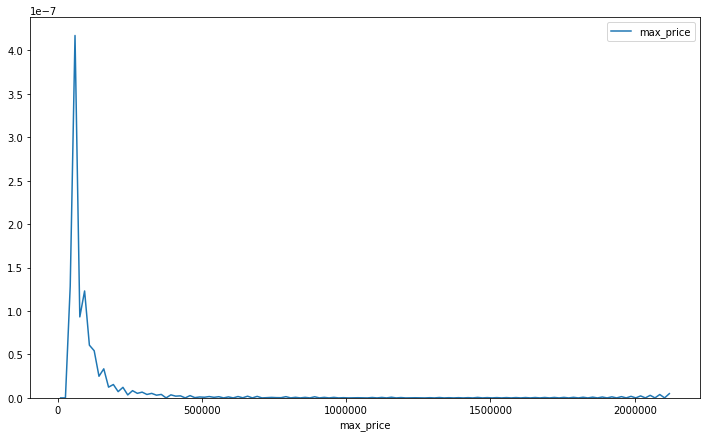

In [35]:
sns.distplot(bn_dist['max_price'], hist = False, kde = True, label = 'max_price')
plt.show()

In [ ]:
bn_price_freqs_no_zero

We'll gather all the final values into one larger bin to save some time there. Let's see how far we can go from the maximum before it gets over 900.

In [ ]:
freq = 0
max_val = bn_price_freqs_no_zero.iloc[0,0].split(' to ')[1]
for index, freq_val in bn_price_freqs_no_zero.iterrows():
    if freq >= 900:
        #max_val = freq_val[0].split(' to ')[1]
        print(freq_val[0].split(' to ')[0], 'to', max_val, ':\t', freq)
        freq = 0

        
    freq = freq + freq_val[1]

In that case, we'll iterate through prices up to £6,000 in £5 increments, up to £12,200 in £200 increments, up to £20,200 in £500 increments, up to £98,200 in £2,000 increments, and straight to the max from £19,201. Hopefully that'll make things a little easier on the Blue Nile servers, and not leave me waiting for decades for the algorithm to finish.

In [ ]:
def get_bn_data():
    """
    Loops through all the price values, scrapes the results and stores
    it into a dataframe.
    """
    
    def get_num_results():
        """
        Scrapes the number of results shown in the price range.    
        """
        results_path = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[2]/div[4]/button[1]/span[2]')
        # Scrape the HTML and clean
        results_val = cleanhtml(str(BeautifulSoup(results_path.get_attribute('innerHTML'))))
        # Strip the punctuation, and convert to integer
        results_val = int(re.sub(r'[^\w\s]','', results_val))
        return(results_val)    
    
    bn_headers = []
    
    # Isolate the table headers HTML
    headers_data = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/section/div/div/div[1]/div')
    headers_html = BeautifulSoup(headers_data.get_attribute('innerHTML'))
    
    # Get the header values
    for div in headers_html.find_all('div'):
        for header in div.find_all('span'):
            bn_headers.append(cleanhtml(str(header)))
    bn_headers = list(filter(('').__ne__, bn_headers))
    bn_headers.remove('Compare')
    
    # Create a dataframe with our new headers
    bn_df = pd.DataFrame(columns=bn_headers)
    
    # Min and max price locations
    min_price_box = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[7]/div[2]/div/div[1]/input[1]')
    max_price_box = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[7]/div[2]/div/div[1]/input[2]')
    
    
    # Assign a default range value
    price_range = 5
    
    # Get the min and max values (without £ and comma values)
    min_price_value = int(min_price_box.get_attribute('value')[1:].replace(',', ''))
    max_price_value = int(max_price_box.get_attribute('value')[1:].replace(',', ''))
    
    # Find a neutral zone to click on
    neutral = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/div[1]/div[2]/div[3]/div[7]/div[1]/h3')
    
    ####### EDITS HERE ########        

    def bn_table_scrape_loop(price_range):
        
        # Loop through prices to limit numbers displayed
        for min_val in range(min_price_value, max_price_value, price_range):   
            # Edit min price
            min_price_box.click()
            min_price_box.send_keys(Keys.BACKSPACE)
            min_price_box.send_keys(str(min_val))
            neutral.click()
            time.sleep(random.uniform(0.3,2))
            
            # Edit max price
            max_price_box.click()
            max_price_box.send_keys(Keys.BACKSPACE)
            time.sleep(2)
            max_price_box.send_keys(str(min_val+price_range)) 
            neutral.click()
    
            time.sleep(random.uniform(0.3,2))
            
            table_web_source = browser.find_element_by_xpath('//*[@id="react-app"]/div/div/div/section[1]/section/div/div/div[2]')
            table_html = BeautifulSoup(table_web_source.get_attribute('innerHTML'))
            
            # Scrape the table! First get the raw table html
            table_rows_html = table_html.find_all('a',{'class':'grid-row row '})
            time.sleep(random.uniform(0.3,3))
                
            # Then loop through each row 
            for row in table_rows_html:
                bn_data = []
                # And loop through each value
                for value in row.find_all('span'):
                    bn_data.append(cleanhtml(str(value)))
                
                bn_data = list(filter(('').__ne__, bn_data)) # Remove all empty values
                del bn_data[4] # Delete index 4 in list as it returns two dupe vals - unique to their HTML
                #print(bn_data)
                bn_df = bn_df.append(dict(zip(bn_headers,bn_data)),ignore_index=True)

    
        return(bn_df)

In [ ]:
get_bn_data()

In [ ]:
for min_val in range(0, 100, 5):
    if min_val <= 20:
        print(5)
    elif min_val <= 60:
        print(20)
    else:
        print(40)